Kaggle Titanic竞赛

基于yassineghouzam的[kernel](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling)，部分地方略有调整。目前最好成绩是0.79904（TOP 20%）。

主要的思路是：

1. 去除干扰点
2. 缺失值处理（Age：填充；Cabin：单独作为一类……）
3. 特征转换
4. 学习方法对比，学习曲线绘制，不同方法的特征权重、相关性
5. 交叉验证
6. 参数寻优
7. 学习方法组合

In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

from xgboost import XGBClassifier

%matplotlib inline

sns.set(style='white', context='notebook', palette='deep')

## 1 Read Data

### 1.1 训练集

In [263]:
train_df = pd.read_csv('input/train.csv')
display(train_df.head())

train_df.info()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB



### 1.2 测试集：

In [264]:
test_df = pd.read_csv('input/test.csv')
display(test_df.head())

test_df.info()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### 1.3 去除干扰点

In [265]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train_df, 2, ["Age","SibSp","Parch","Fare"])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [266]:
train_df.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


干扰点28、89、342是由于价格太高，其余的则是SibSp太多。

In [267]:
# Drop outliers
train_df = train_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 1.4 合并数据

In [432]:
full_df = pd.concat([train_df, test_df], ignore_index=True)

full_df

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


## 2 带缺失值的特征处理

### 2.1 Embarked

Embarked只有两个缺失值，可以采用出现次数最多的港口（S）进行填充。

在这里，我认为相同的船舱等级、相同的港口登船的票价应该也是接近的，用这种方式进行填充。

我先对Pclass（=1）的乘客按各港口求票价中值，取票价中值与乘客票价最接近的港口（C）来进行填充。

In [433]:
full_df.loc[full_df['Embarked'].isnull(), :]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
60,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
821,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [434]:
full_df[(full_df['Pclass']==1)].groupby('Embarked')['Fare'].median()

Embarked
C    76.7292
Q    90.0000
S    52.0000
Name: Fare, dtype: float64

In [435]:
full_df.loc[full_df['Embarked'].isnull(), 'Embarked'] = 'C'

### 2.2 Fare

我们用与缺失值相同Pclass、相同Embarked的票价中值来填充。

In [436]:
full_df.loc[full_df['Fare'].isnull(), :]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1033,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [437]:
full_df.loc[full_df['Fare'].isnull(), 'Fare'] = \
full_df[(full_df['Pclass']==3) & (full_df['Embarked']=='S')]['Fare'].median()

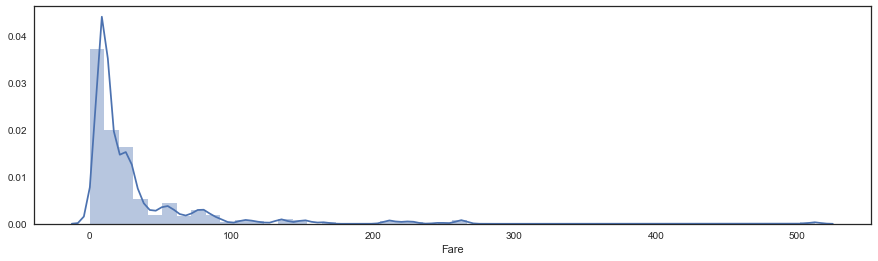

In [438]:
plt.figure(figsize=(15, 4))
g = sns.distplot(full_df['Fare'])

可以看出Fare的分布极不均衡，这样的条件下即使做了scale，模型也会给价格高的样本比较高的权重，所以，这里对Fare进行log处理。

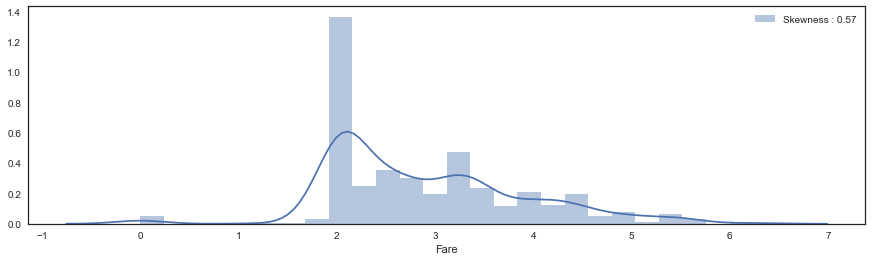

In [439]:
# Apply log to Fare to reduce skewness distribution
full_df["Fare"] = full_df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

plt.figure(figsize=(15, 4))
g = sns.distplot(full_df['Fare'], label="Skewness : %.2f"%(full_df["Fare"].skew()))
g = g.legend(loc="best")

### 2.3 Age

先看看Pclass、Parch、SibSp、Sex与Age的关系。

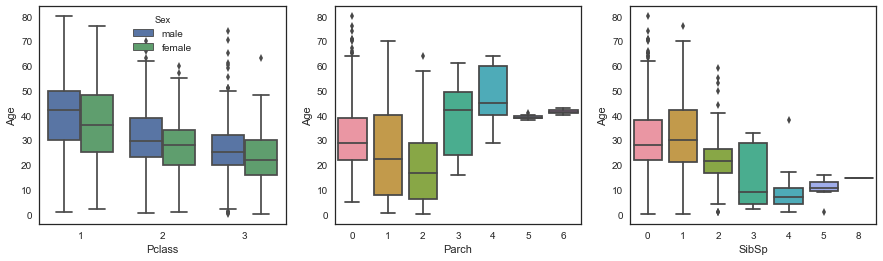

In [440]:
df_age = full_df.loc[~full_df['Age'].isnull(), :]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

g = sns.boxplot(x='Pclass', y='Age', hue='Sex', data=df_age, ax=axs[0])
g = sns.boxplot('Parch', 'Age', data=df_age, ax=axs[1])
g = sns.boxplot('SibSp', 'Age', data=df_age, ax=axs[2])

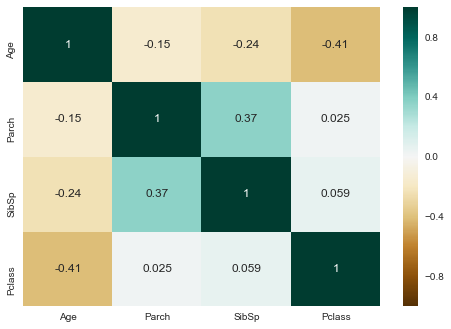

In [441]:
g = sns.heatmap(df_age[['Age', 'Sex', 'Parch', 'SibSp', 'Pclass']].corr(), cmap='BrBG', annot=True)

Age与Pclass、SibSp、Pclass的相关性都挺强的。Sex与Age的关系不是很强，但是Pclass结合Sex应该比直接使用Pclass更精确，所以Sex也用上。

In [442]:
age_med = full_df['Age'].median()

for id in full_df['PassengerId']:
    passenger = full_df[full_df['PassengerId']==id].iloc[0]

    if np.isnan(passenger['Age']):
        age_pred = full_df['Age'][(full_df['Pclass'] == passenger['Pclass']) 
                                    & (full_df['Sex'] == passenger['Sex'])
                                    & (full_df['SibSp'] == passenger['SibSp'])
                                    & (full_df['Parch'] == passenger['Parch'])
                                      ].median()

#         if np.isnan(age_pred):
#             age_pred = full_df['Age'][(full_df['Pclass'] == passenger['Pclass']) 
#                                         & (full_df['SibSp'] == passenger['SibSp'])
#                                         & (full_df['Parch'] == passenger['Parch'])
#                                           ].median()
            
#         if np.isnan(age_pred):
#             age_pred = full_df['Age'][(full_df['Pclass'] == passenger['Pclass']) 
#                                         & (full_df['Parch'] == passenger['Parch'])
#                                          ].median()
        
#         if np.isnan(age_pred):
#             age_pred = full_df['Age'][full_df['Pclass'] == passenger['Pclass']].median()
            
        if np.isnan(age_pred):
            age_pred = age_med

        full_df.loc[full_df['PassengerId']==id, 'Age'] = age_pred

## 3 特征处理


### 3.1 Name

Name中提取Title

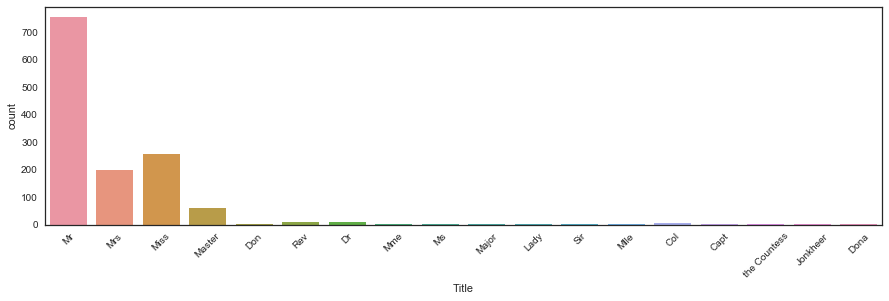

In [443]:
full_df['Title'] = pd.Series([name.split(',')[1].split('.')[0].strip() for name in full_df['Name']])

plt.figure(figsize=(15, 4))
g = sns.countplot(full_df['Title'])
g = plt.setp(g.get_xticklabels(), rotation=45)

In [444]:
full_df['Title'] = full_df['Title'].replace(
    ['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 
    'Rare'
)
full_df['Title'] = full_df['Title'].map(
    {"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3}
)
full_df['Title'] = full_df['Title'].astype(int)

full_df['Title'].value_counts()

2    753
1    457
0     60
3     29
Name: Title, dtype: int64

In [446]:
full_df.drop('Name', axis=1, inplace=True)

full_df = pd.get_dummies(full_df, columns = ["Title"])

full_df.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title_0,Title_1,Title_2,Title_3
0,22.0,NaN,S,1.981001,0,1,3,male,1,0.0,A/5 21171,0,0,1,0
1,38.0,C85,C,4.266662,0,2,1,female,1,1.0,PC 17599,0,1,0,0
2,26.0,NaN,S,2.070022,0,3,3,female,0,1.0,STON/O2. 3101282,0,1,0,0
3,35.0,C123,S,3.972177,0,4,1,female,1,1.0,113803,0,1,0,0
4,35.0,NaN,S,2.085672,0,5,3,male,0,0.0,373450,0,0,1,0


### 3.2 Sex

In [447]:
full_df['Sex'] = full_df['Sex'].map({'male': 0, 'female': 1})

full_df.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title_0,Title_1,Title_2,Title_3
0,22.0,NaN,S,1.981001,0,1,3,0,1,0.0,A/5 21171,0,0,1,0
1,38.0,C85,C,4.266662,0,2,1,1,1,1.0,PC 17599,0,1,0,0
2,26.0,NaN,S,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,0,1,0,0
3,35.0,C123,S,3.972177,0,4,1,1,1,1.0,113803,0,1,0,0
4,35.0,NaN,S,2.085672,0,5,3,0,0,0.0,373450,0,0,1,0


### 3.3 Embarked

In [448]:
full_df = pd.get_dummies(full_df, columns = ['Embarked'])

full_df.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title_0,Title_1,Title_2,Title_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,0,0,1,0,0,0,1


### 3.4 Family size

In [449]:
full_df['Fsize'] = full_df['Parch'] + full_df['SibSp'] + 1

# Create new feature of family size
full_df['Single'] = full_df['Fsize'].map(lambda s: 1 if s == 1 else 0)
full_df['SmallF'] = full_df['Fsize'].map(lambda s: 1 if  s == 2  else 0)
full_df['MedF'] = full_df['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
full_df['LargeF'] = full_df['Fsize'].map(lambda s: 1 if s >= 5 else 0)

full_df.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,Title_2,Title_3,Embarked_C,Embarked_Q,Embarked_S,Fsize,Single,SmallF,MedF,LargeF
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0,1,2,0,1,0,0
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,0,0,1,0,0,2,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,0,1,1,1,0,0,0
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,...,0,0,0,0,1,2,0,1,0,0
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,...,1,0,0,0,1,1,1,0,0,0


### 3.5 Cabin

In [450]:
# Replace the Cabin number by the type of cabin 'X' if not
full_df["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in full_df['Cabin'] ])

full_df = pd.get_dummies(full_df, columns = ["Cabin"], prefix="Cabin")

full_df.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title_0,...,LargeF,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,22.0,1.981001,0,1,3,0,1,0.0,A/5 21171,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,2,1,1,1,1.0,PC 17599,0,...,0,0,0,1,0,0,0,0,0,0
2,26.0,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,0,...,0,0,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,4,1,1,1,1.0,113803,0,...,0,0,0,1,0,0,0,0,0,0
4,35.0,2.085672,0,5,3,0,0,0.0,373450,0,...,0,0,0,0,0,0,0,0,0,1


### 3.6 Ticket

In [451]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(full_df.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")

full_df["Ticket"] = Ticket
full_df = pd.get_dummies(full_df, columns = ["Ticket"], prefix="T")

full_df.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title_0,Title_1,...,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X
0,22.0,1.981001,0,1,3,0,1,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,4.266662,0,2,1,1,1,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,26.0,2.070022,0,3,3,1,0,1.0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,35.0,3.972177,0,4,1,1,1,1.0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,35.0,2.085672,0,5,3,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,1


### 3.7 Pclass

In [452]:
full_df["Pclass"] = full_df["Pclass"].astype("category")
full_df = pd.get_dummies(full_df, columns=['Pclass'], prefix="Pc")

full_df.head()

,Age,Fare,Parch,PassengerId,Sex,SibSp,Survived,Title_0,Title_1,Title_2,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,1,0,1,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,2,1,1,1.0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,3,1,0,1.0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,4,1,1,1.0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,5,0,0,0.0,0,0,1,...,0,0,0,0,0,0,1,0,0,1


### 3.8 Drop

In [453]:
full_df.drop([ 'PassengerId'], axis=1, inplace=True)

full_df.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Title_0,Title_1,Title_2,Title_3,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


## 4 数据集

In [454]:
train = full_df[:len(train_df)]
train['Survived'] = train['Survived'].astype(int)

test = full_df[len(train_df):]
test.drop("Survived", axis = 1, inplace=True)

X = train.drop('Survived', axis=1)
y = train['Survived']

X_test = test

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## 5 学习

### 5.1 基础学习

In [455]:
kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(XGBClassifier())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X=X, y=y, scoring="accuracy", cv=kfold, n_jobs=4))

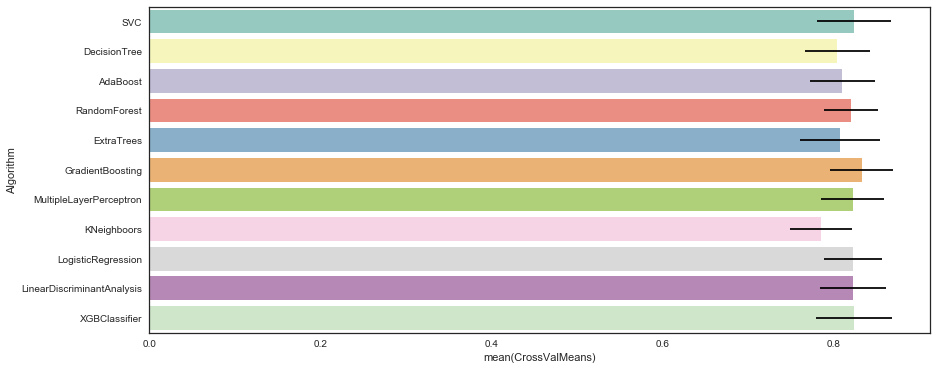

In [456]:
cv_means = []
cv_stds = []
for result in cv_results:
    cv_means.append(result.mean())
    cv_stds.append(result.std())
    
cv_res = pd.DataFrame(
    {"CrossValMeans":cv_means,
     "CrossValerrors": cv_stds,
     "Algorithm":["SVC","DecisionTree","AdaBoost","RandomForest","ExtraTrees",
                  "GradientBoosting","MultipleLayerPerceptron","KNeighboors",
                  "LogisticRegression","LinearDiscriminantAnalysis", "XGBClassifier"
                 ]
    }
)

plt.figure(figsize=(14, 6))
g = sns.barplot(x='CrossValMeans', y='Algorithm', data=cv_res, palette="Set3", orient="h", **{'xerr':cv_stds})

### 5.2 参数选择

#### 5.2.1 AdaBoost

In [457]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC)

ada_param_grid = {
    "base_estimator__criterion" : ["gini", "entropy"],
    "base_estimator__splitter" :   ["best", "random"],
    "algorithm" : ["SAMME","SAMME.R"],
    "n_estimators" :[3, 4],
    "random_state": [3, 7],
    "learning_rate":  [0.1, 0.15, 0.2, 1]
}

gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, scoring="accuracy", cv=kfold, n_jobs=4, verbose=1)
gsadaDTC.fit(X, y)

ada_best = gsadaDTC.best_estimator_

gsadaDTC.best_score_

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 1280 out of 1280 | elapsed:   11.0s finished


0.81838819523269013

#### 5.2.2 ExtraTrees 

In [458]:
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {
    "max_depth": [None],
    "max_features": [1, 3, 10],
    "min_samples_split": [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [False],
    "n_estimators" :[100,300],
    "criterion": ["gini"]
}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, scoring="accuracy", cv=kfold, n_jobs=4, verbose=1)
gsExtC.fit(X, y)

ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   43.5s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   52.7s finished


0.82973893303064694

#### 5.2.3 RandomForestClassifier

In [459]:
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {
    "max_depth": [None],
    "max_features": [1, 3, 10],
    "min_samples_split": [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [False],
    "n_estimators" :[100,300],
    "criterion": ["gini"]
}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X, y)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   45.9s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   55.9s finished


0.83087400681044266

#### 5.2.4 Gradient boosting

In [460]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {
    'loss' : ["deviance"],
    'n_estimators' : [100,200,300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [4, 8],
    'min_samples_leaf': [100,150],
    'max_features': [0.3, 0.1] 
}

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X, y)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 308 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   27.2s finished


0.83200908059023837

#### 5.2.5 LogisticRegression

In [461]:
LR = LogisticRegression()
lr_param_grid = {
    'C' : [0.1, 1, 10, 30]
}

gsLR = GridSearchCV(LR, param_grid = lr_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsLR.fit(X, y)

LR_best = gsLR.best_estimator_

# Best score
gsLR.best_score_

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Done  33 out of  40 | elapsed:    4.7s remaining:    0.9s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    4.7s finished


0.82406356413166859

#### 5.2.6 SVC

In [462]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {
    'kernel': ['rbf'], 
    'gamma': [0.001, 0.01, 0.1, 1],
    'C': [1, 10, 50, 100,200,300, 1000]
}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X, y)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.1s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   29.4s finished


0.8354143019296254

#### 5.3.7 xgboost

In [463]:
XGBC = XGBClassifier({'objective': 'binary:logistic'})
xgb_param_grid = {
    'random_state': [0],
    'min_child_weight': [5],
    'max_depth': [3],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 1000],
    'subsample': [1],
    'seed': [0],
    'colsample_bytree': [0.8, 1],
}

gsXGBC = GridSearchCV(XGBC, param_grid = xgb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsXGBC.fit(X, y)

XGBC_best = gsXGBC.best_estimator_

# Best score
gsXGBC.best_score_

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:   19.5s finished


0.83654937570942112

### 5.3 绘制学习过程

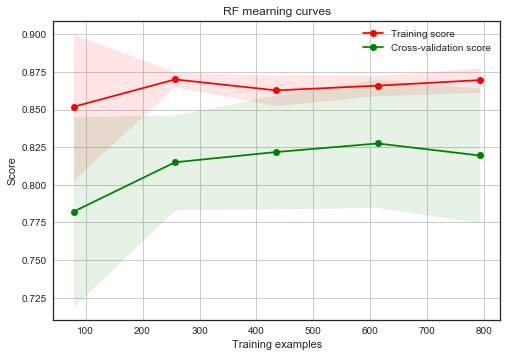

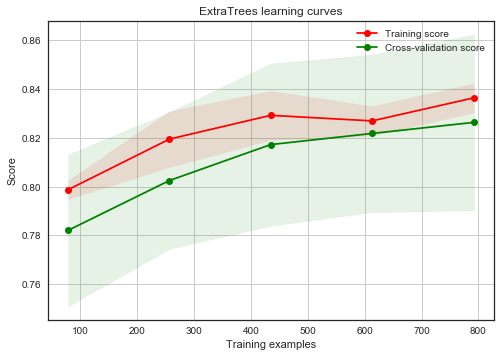

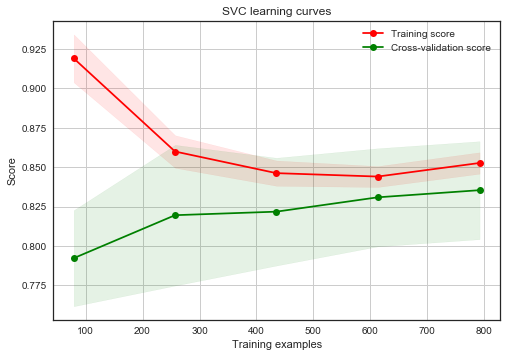

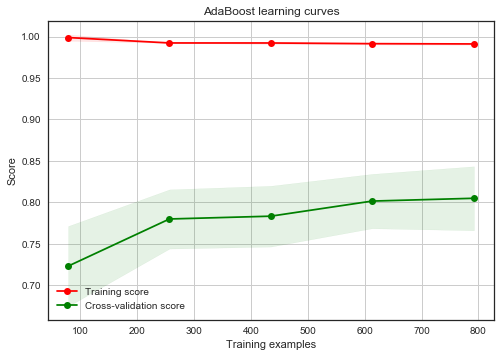

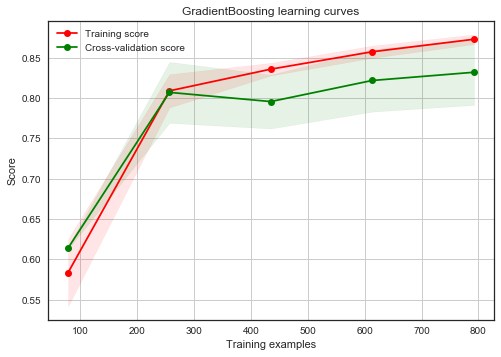

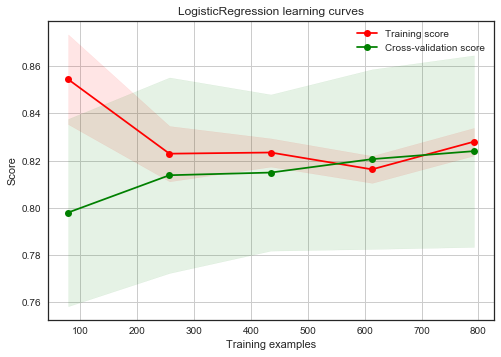

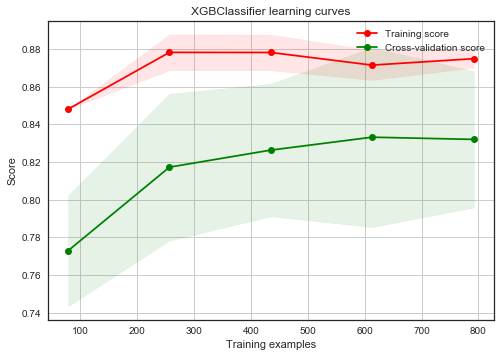

In [464]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X,y,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X,y,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X,y,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X,y,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X,y,cv=kfold)
g = plot_learning_curve(gsLR.best_estimator_,"LogisticRegression learning curves",X,y,cv=kfold)
g = plot_learning_curve(gsXGBC.best_estimator_,"XGBClassifier learning curves",X,y,cv=kfold)


### 5.4 特征重要程度

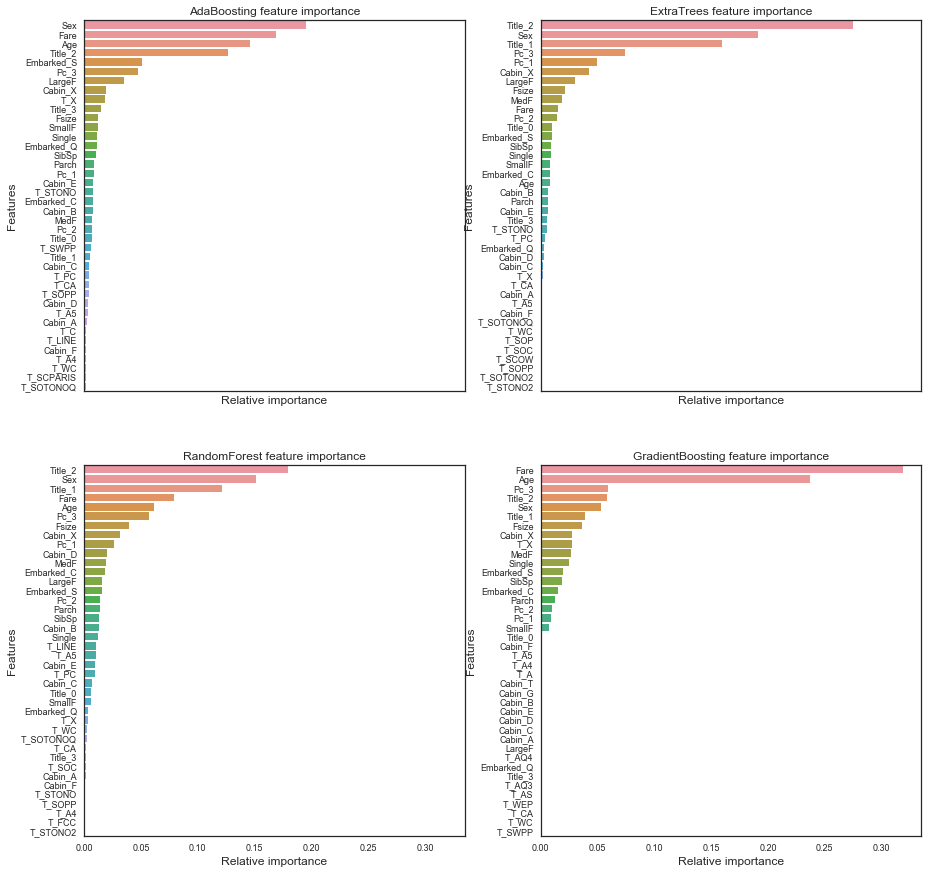

In [465]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

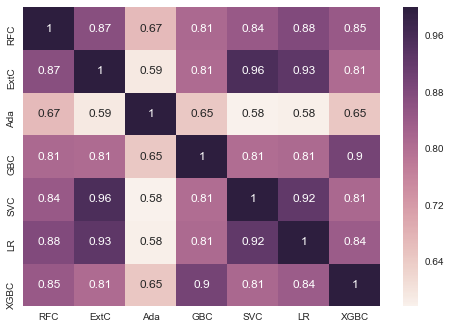

In [466]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")
test_Survived_LR = pd.Series(LR_best.predict(test), name="LR")
test_Survived_XGBC = pd.Series(XGBC_best.predict(test), name="XGBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,
                              test_Survived_GBC, test_Survived_SVMC, test_Survived_LR,
                              test_Survived_XGBC],
                             axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

### 5.5 组合学习器

经过理论分析和实践，以下选择学习器来组合效果比较好：

- gbc与xgbc保留一个。

- SVC、LR关联比较大，保留SVC。

In [467]:
votingC = VotingClassifier(
    estimators=[
        ('rfc', RFC_best), 
        ('extc', ExtC_best),
#         ('lr', LR_best), 
#         ('gbc',GBC_best),
        ('svc',SVMC_best),
        ('ada',ada_best),
        ('xgbc',XGBC_best)
    ], 
    voting='soft', n_jobs=4
)

votingC = votingC.fit(X, y)

### 5.6 预测结果

In [468]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([test_df["PassengerId"],test_Survived],axis=1)

results.to_csv("output/ensemble_python_voting.csv",index=False)